<div class="alert alert-block alert-info" >
    <h1>Machine Learning: Assignment 5</h1>
    <h2>This is a three week assignment</h2>
    <h3>General Information:</h3>
    <p>Feel free to add cells if required.<br> Feel free to write your own function block to reduce the redundancy.<br> Answers belong into the corresponding cells (below the question). <br><br> If you encounter empty cells underneath the answer that can not be edited, please ignore them, they are for testing purposes.<br><br>When editing an assignment there can be the case that there are variables in the kernel. To make sure your assignment works, please restart the kernel and run all cells before submitting (e.g. via <i>Kernel -> Restart & Run All</i>). We don't consider that respective solution if you make this mistake (no excuse).</p>
    <br><br><b> Plot should have axis labels, grid, legend, title, atleast size 10X10 also give proper comments, function name, variable names to your coding, if you didn't follow the instructions there will be a reduction in the points.</b><br><br> 
     <br><br><b> Write sudo-code if you didn't get output or left out of time so that you will be awarded with atmost 50% of marks for that particular session.</b><br><br>
    <h3>Submission:</h3>
    <p>Use the following naming convention for your submissions: LA_FirstnameLastname_dateOfLecture, e.g LA_JohnDoe_YYMMDD
     <br><br>Please submit your notebook via LEA. The assignment is due on <b>$12^{th}$ June, Saturday at 18:00.</b> </p>
    <h3>Group Work:</h3>
    <p>You are allowed to work in groups of up to two people. Please enter the UID (your username here) of each member of the group into the next cell. We apply plagiarism checking, so do not submit solutions from other people except your team members. If an assignment has a copied solution, the task will be graded with 0 points for all people with the same solution.</p>
    <p><b>YOU SHOULD ONLY SUBMIT EXACTLY ONE PER GROUP</b></p>
    <h3>Questions about the Assignment:</h3>
    <p>If you have questions about the assignment please post them in the LEA forum before the deadline. Don't wait until the last day to post questions.</p></div>

In [1]:
'''
Group Work:
Enter the UID (i.e. student2s) of each team member into the variables. 
If you work alone please leave the second variable empty, or extend the list if necessary.
'''
member1 = 'sdeuss2s'
member2 = 'mhelap2s'

# Ensembles  [100 points]

### Foundation pen dataset  
1. The dataset provided consists of 8 classes (folder name) each classes contains 48 files of 30 observations each.
2. Total of 12 pens are tested in 4 nest combination with three different velcity (3.4m, 4.5m and 9.0m).
3. Each nest has 30 observations.
4. The files consists of features and not the raw data.

#### Note:- You don't need to watch the Lecture slide 7, 8, 9 to solve this but to understand whats happening you should go through it.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import sklearn
#Import other libraries here
from os import listdir
from os.path import isdir, isfile, join
from typing import NamedTuple
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from typing import Callable, Tuple
from tqdm import tqdm
import csv

## Task 1: Preprocessing [35 points]

### 1. Load the data and display. Below the code cell write the adaboost algorithm (Just the 4 steps, no need explanation)[5 points]

- Initialize the weights by setting all weights to $w_n=\frac{1}{N}$. <br>
    <br>
- For the iterations(no of times we repeat the reweighting and reclassifying )
    - Train the classifier using current weights by minimizing weighted error function $J_m=\sum_{n=1}^N w_m^{(m)}I(h_m(x)\neq t_n)$
    - Estimate the weighted error of this classifier on X
    - Calculate the weighing coeficients
    - Update weighting coeficients
    
- Repeat the last 4 steps


### 2. Extract the data [20 points]
- Extract the data based on velocity 4.5m.
- You should crawl into all the folder and combine only the data/file of velocity 4.5m for each class along with the class label.
- Remove the insignificant columns (should have 46 column including the class label)
- Display as pandas table

In [13]:
Observation = NamedTuple("Observation", 
                         path=str, file_name=str, df=pd.DataFrame, 
                         class_=str, nest=int, configuration=str)
    
def extract_data(path, *, velocity="4,5m", only_nest=None) -> pd.DataFrame:
    """
    Loads all csv files from a given directory. Differentiates based on velocity in file name.
    Returned dataframe will contain additional information parsed from the file name - configuration and nest.
    """
    observations = []

    for folder in listdir(path):
        if isdir(join(path, folder)):
            for file_name in listdir(join(path, folder)):
                path_to_file = join(path, folder, file_name)
                if isfile(path_to_file) and file_name.lower().endswith(".csv") and velocity in file_name:

                    # extracts additional info from file name: G 2-3-4-1 - 4,5m - Nest-1.CSV
                    # nasty, but gets the job done the easiest way
                    class_, configuration, _, _, _, nest = file_name.split(" ")
                    nest = nest.split(".")[0]
                    nest = int(configuration.split("-")[1])
                    
                    if only_nest and only_nest is not nest:
                        continue

                    with open(path_to_file) as f:
                        reader = csv.reader(f, delimiter=";")

                        rows = list(reader)
                        for row in rows:
                            for index, entry in enumerate(row):
                                try:
                                    replaced = entry.replace(",", ".")
                                    row[index] = float(replaced)
                                    assert isinstance(row[index], float)

                                except Exception as e:
                                    row[index] = None
                    df = pd.DataFrame(rows)

                    df.drop([46, 47, 48], axis=1, inplace=True)
                    rename_dict = {index:f"feature_{index}" for index in df.columns}
                    df.rename(columns = rename_dict, inplace = True)

                    df["class"] = class_
                    df["configuration"] = configuration
                    df["nest"] = nest
                    
        
                    observations.append(
                        Observation(
                            path=path_to_file,
                            file_name=file_name,
                            df=df,
                            class_=class_, nest=nest, configuration=configuration)
                    )

    print(f"Read {len(observations)} csv files from the folder 'dataset'")
    
    
    df =  pd.concat([o.df for o in observations])
    return df.reset_index(drop=True)

df = extract_data("./dataset/")

df

Read 112 csv files from the folder 'dataset'


feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0         5.390      4.987      2.817      4.927      5.390      4.987   
1         1.206      1.696      1.206      1.696      1.113      1.337   
2         2.842      3.869      2.842      3.005      1.598      3.869   
3         5.221      3.434      5.221      3.266      4.323      3.434   
4         1.514      2.458      0.844      1.876      1.514      2.458   
...         ...        ...        ...        ...        ...        ...   
3355     18.774      9.963     11.189      7.380     18.774      9.963   
3356     18.805     14.809      6.540      6.739     18.805     14.809   
3357     25.626     21.558     10.428     16.856     25.626     15.265   
3358     18.284      9.000     16.638      7.150     18.284      9.000   
3359     11.304     12.623      5.353     10.485     11.304     12.623   

      feature_6  feature_7  feature_8  feature_9  ...  feature_39  feature_40  \
0         0.110      0.094      2.425      2.121  ...       0.005      37.428   
1         0.148      0.121      0.397      0.548  ...       0.005      36.496   
2         0.112      0.088      0.709      1.625  ...       0.006      36.458   
3         0.121      0.083      1.231      0.891  ...       0.009      39.030   
4         0.150      0.148      0.407      0.933  ...       0.004      29.216   
...         ...        ...        ...        ...  ...         ...         ...   
3355      0.067      0.019      4.864      2.986  ...       0.008      78.101   
3356      0.030      0.020      4.460      2.780  ...       0.002      62.296   
3357      0.021      0.012      7.383      4.497  ...       0.002      86.807   
3358      0.133      0.021      5.292      1.941  ...       0.013      82.710   
3359      0.030      0.013      3.378      3.474  ...       0.002      56.227   

      feature_41  feature_42  feature_43  feature_44  feature_45  class  \
0         35.093     284.243     295.648      22.222      21.809      G   
1         32.712     271.392     314.718      24.481      25.659      G   
2         41.151     293.074     372.547      24.812      24.880      G   
3         36.328     335.335     278.140      22.923      21.742      G   
4         36.663     251.652     312.213      25.021      26.803      G   
...          ...         ...         ...         ...         ...    ...   
3355      56.247    1053.381     600.858      27.351      17.462    FVL   
3356      59.770     700.861     637.943      18.280      16.607    FVL   
3357      74.463    1010.532     721.337      29.582      19.824    FVL   
3358      59.509     950.972     716.392      30.398      18.429    FVL   
3359      63.857     642.651     677.876      17.102      16.631    FVL   

      configuration  nest  
0           2-3-4-1     3  
1           2-3-4-1     3  
2           2-3-4-1     3  
3           2-3-4-1     3  
4           2-3-4-1     3  
...             ...   ...  
3355        1-2-3-4     2  
3356        1-2-3-4     2  
3357        1-2-3-4     2  
3358        1-2-3-4     2  
3359        1-2-3-4     2  

[3360 rows x 49 columns]

### 3. Correlation [10 points]
- Check the correlation between the features. 

**Hint:** 
1. Use sklearn library to see correlation between features or 
2. Reduce the dimensions using PCA/t-SNE to 3D/2D and then visualize

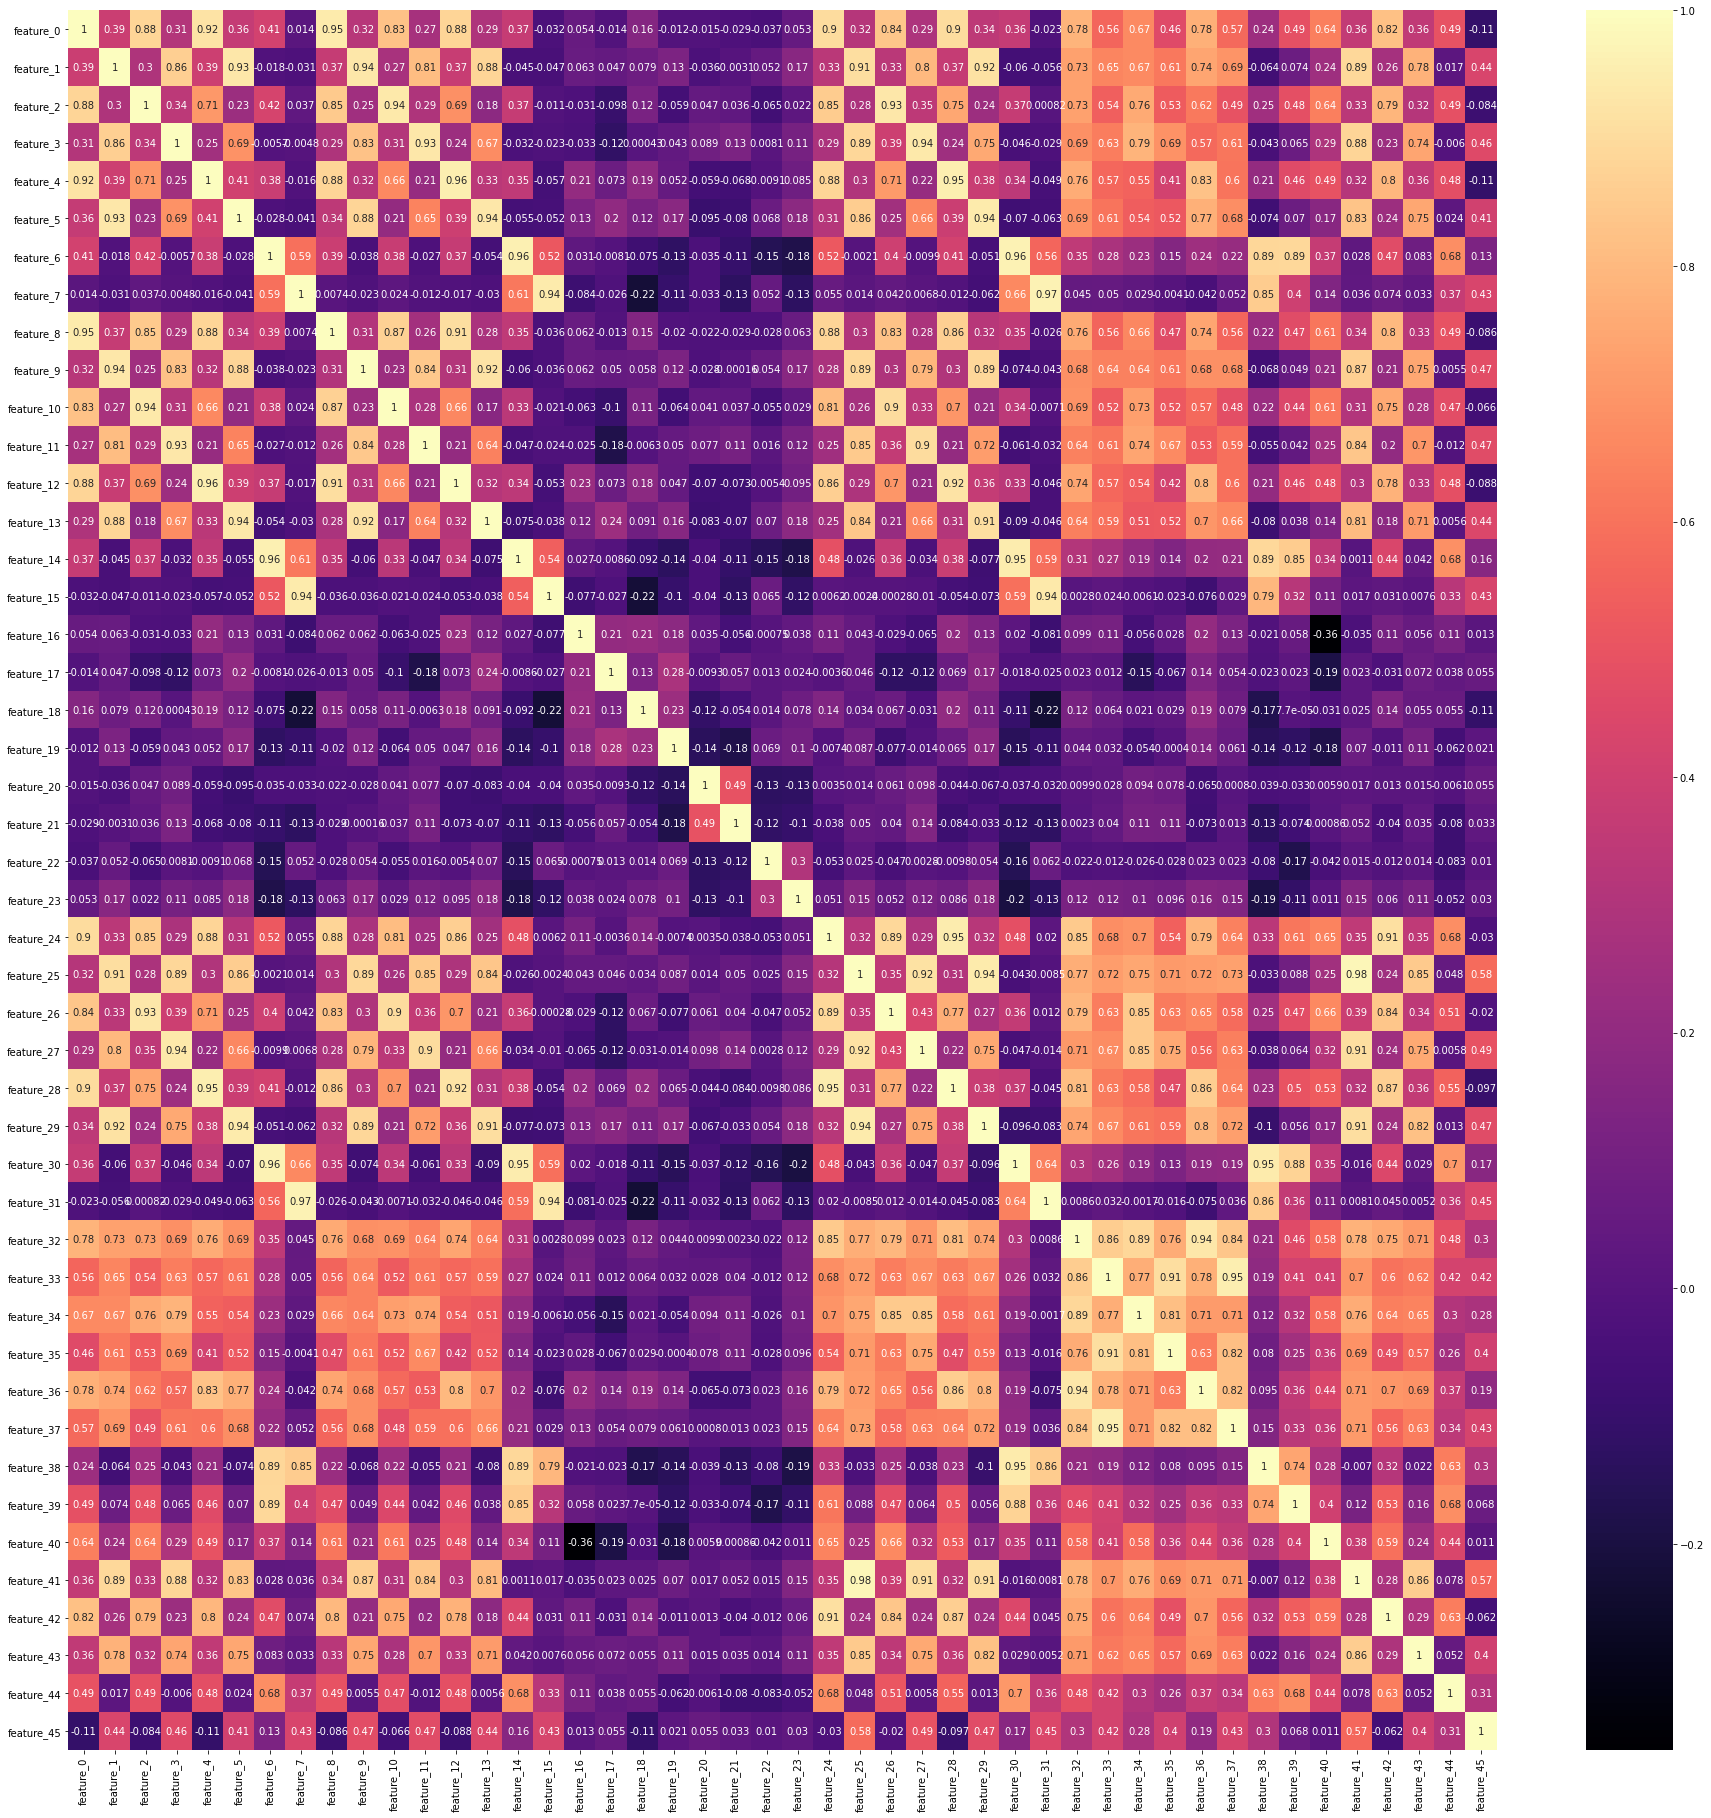

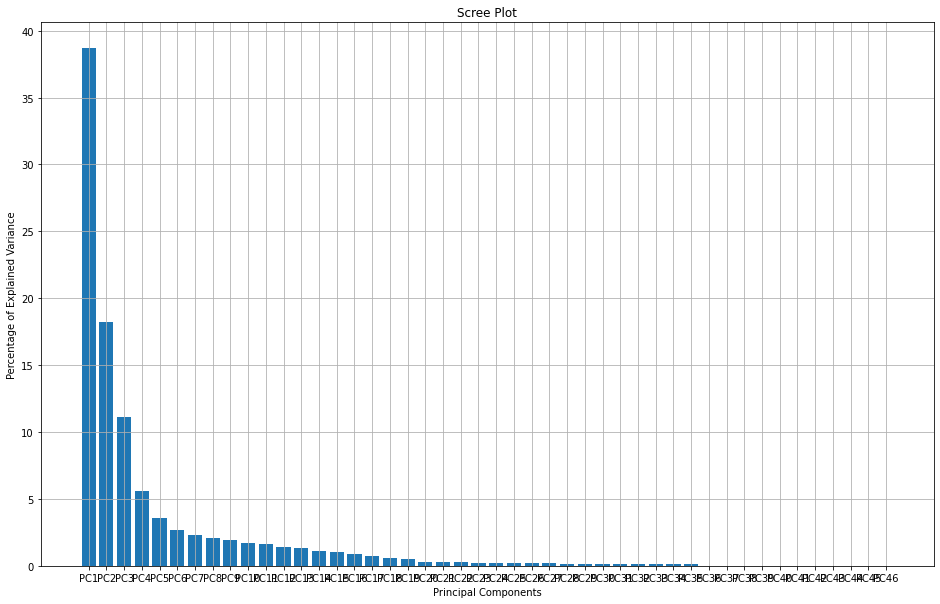

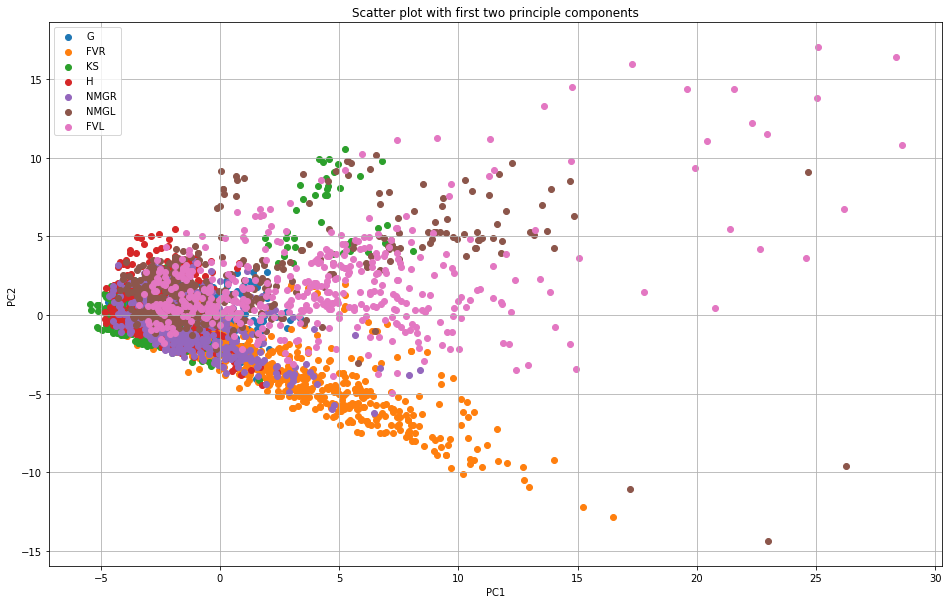

In [14]:
plt.figure(figsize=(32,32))
cor = df[df.columns[:-3]].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.magma)




##PCA 



## Data without the class name, config and nest name
feature_only_data=original_df.drop(['class','configuration','nest'],axis=1)

scaled_data = StandardScaler().fit_transform(feature_only_data)
# scaled_data= preprocessing.scale(new_data.T)

#Using only the first 10 principle components
pca = PCA()
#Perform PCA (what we did for MRC with eigen values n eigen vecots)
pca.fit(scaled_data)
# Now multiply the eigen vectors with the data
pca_data=pca.transform(scaled_data)




#Create a scree plot to show the components that affect mosts
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
scree_fig=plt.figure(figsize=(16,10))
ax1=scree_fig.add_subplot(111)


ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
ax1.set(ylabel='Percentage of Explained Variance',xlabel='Principal Components',title='Scree Plot')
ax1.grid()





pca2 = PCA(n_components=2)
#Perform PCA (what we did for MRC with eigen values n eigen vecots)
pca2.fit(scaled_data)
# Now multiply the eigen vectors with the data
pca2_data=pca2.transform(scaled_data)





all_classes=original_df['class'].unique()
data_with_pca=original_df.copy()
data_with_pca['pca_1']=pca_data[:,0]
data_with_pca['pca_2']=pca_data[:,1]



scatter=plt.figure(figsize=(16,10))
ax2=scatter.add_subplot(111)


ax2.set(ylabel='PC2',xlabel='PC1',title='Scatter plot with first two principle components')




for class_name in all_classes:
    


    xx=data_with_pca.loc[data_with_pca['class'] == class_name]['pca_1'].tolist()
    yy=data_with_pca.loc[data_with_pca['class'] == class_name]['pca_2'].tolist()
    ax2.scatter(xx,yy,label=class_name)
    


ax2.legend()
ax2.grid()
plt.show()





#################################
##References
#################################
#https://www.youtube.com/watch?v=Lsue2gEM9D0








## Task 2: Ensemble Method [30 points]

###  Apply the methods using sklearn library  

- Split the data into training and testing sets (80-20%) 
- Train and test the model (have n_estimator = 100) for 
    - AdaBoost[15 points] 
    - Random Forest [15 points]


Splitted data with 3360 rows into sets with 2688 rows for training and 672 for testing
Fitting AdaBoostClassifier with 100 estimators


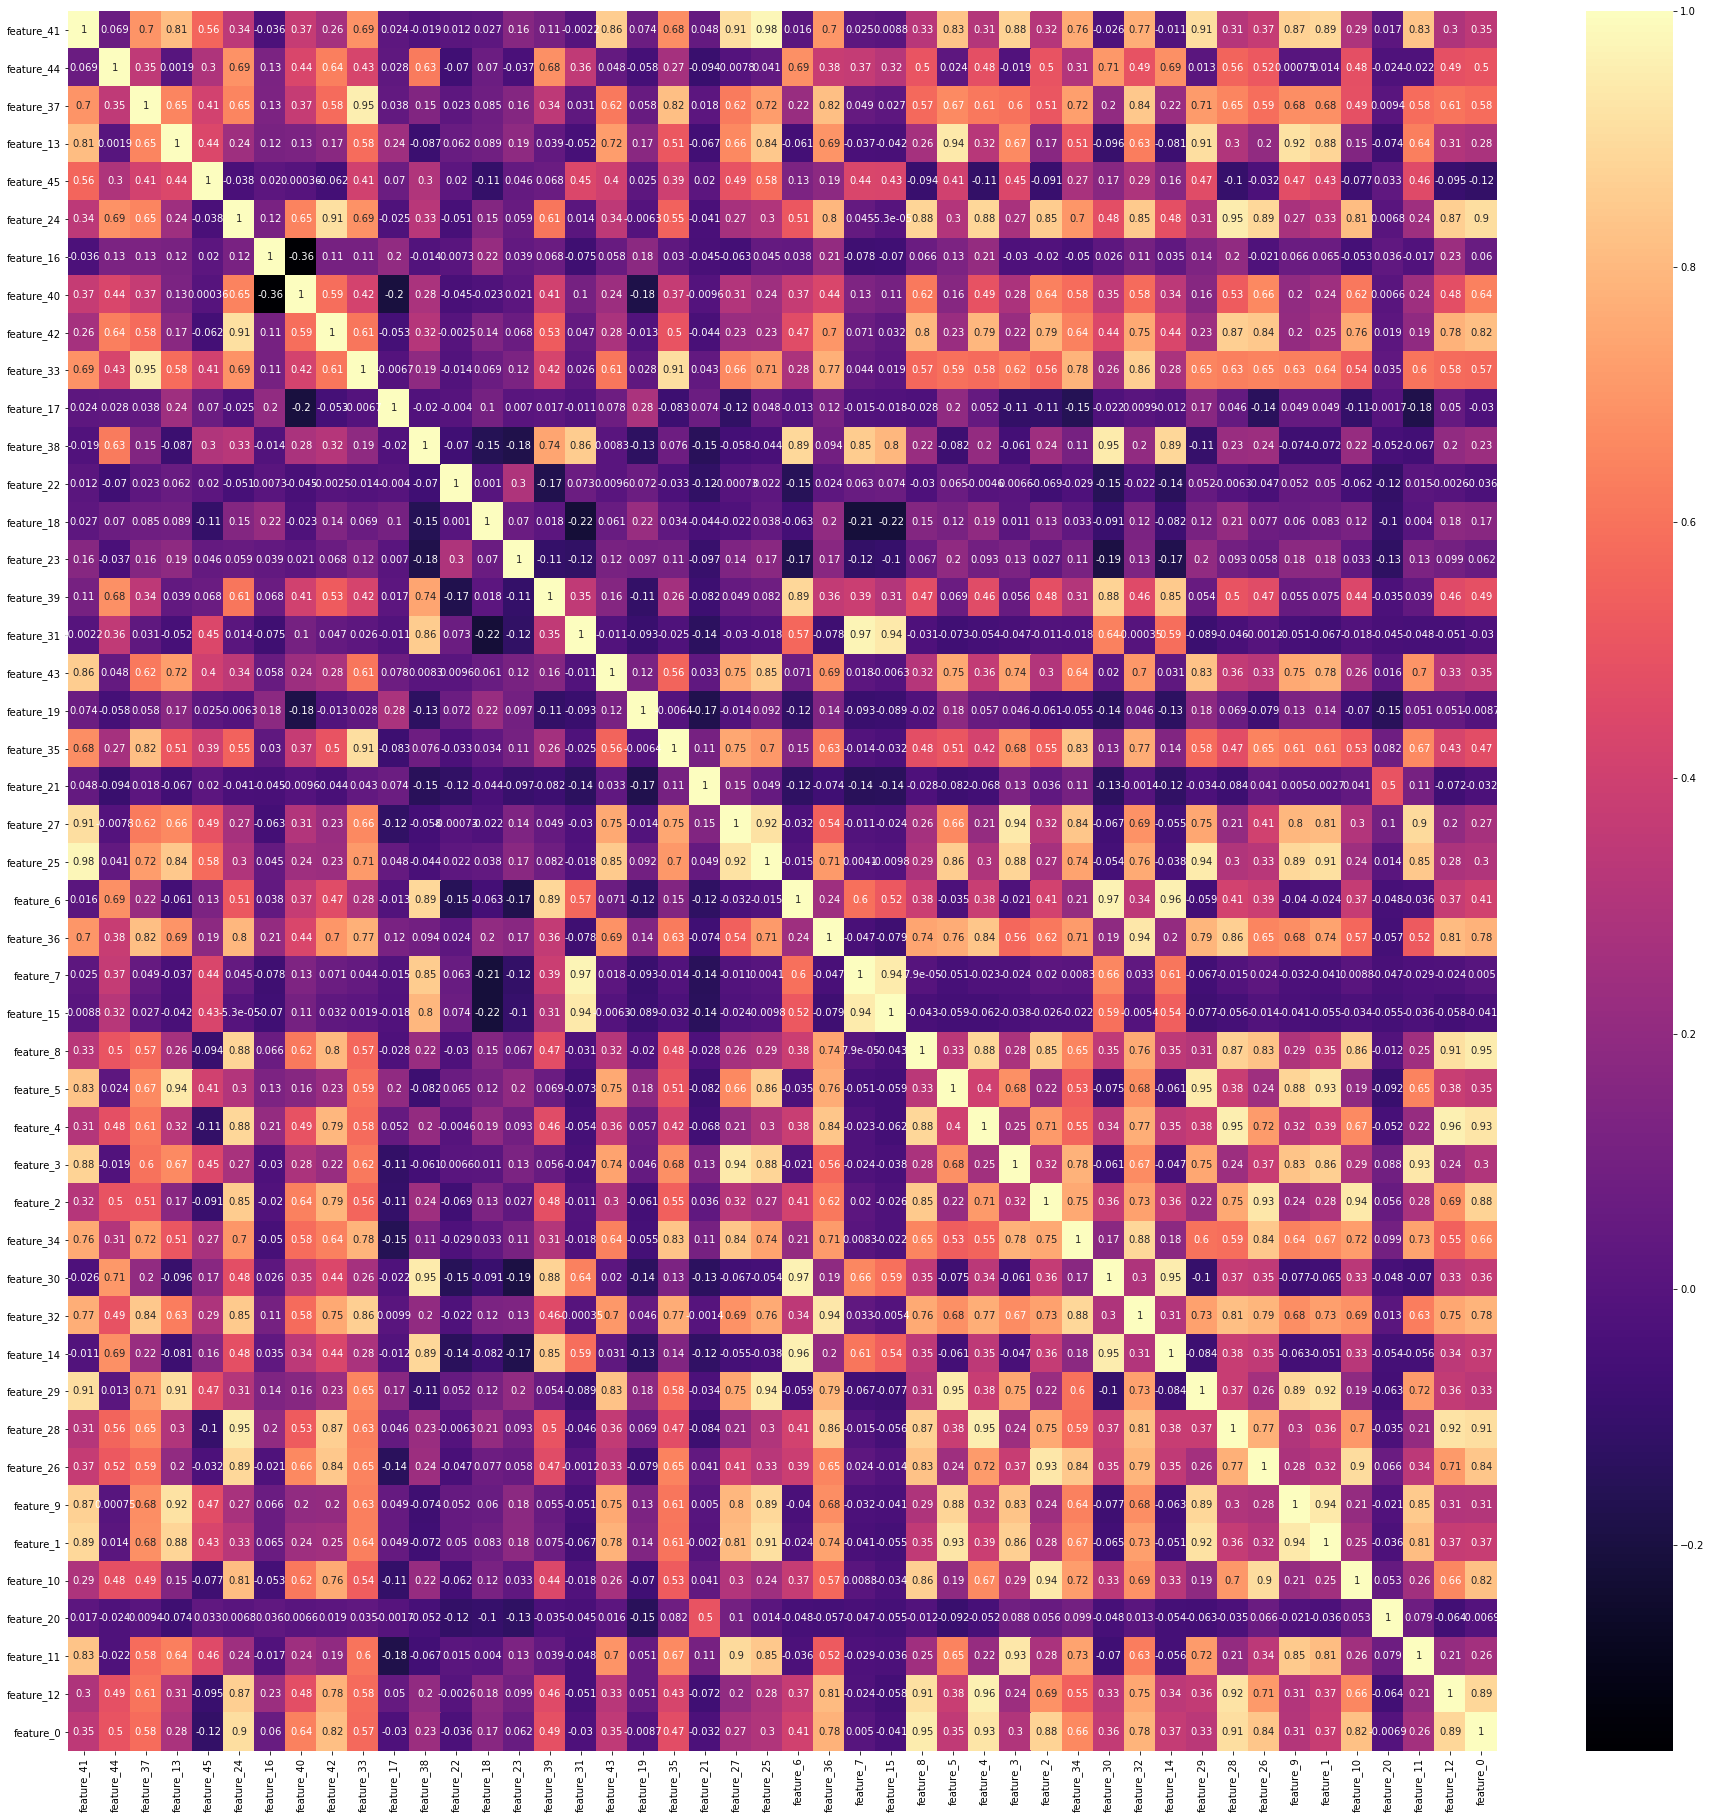

Fitting RandomForrestClassifier with 100 estimators


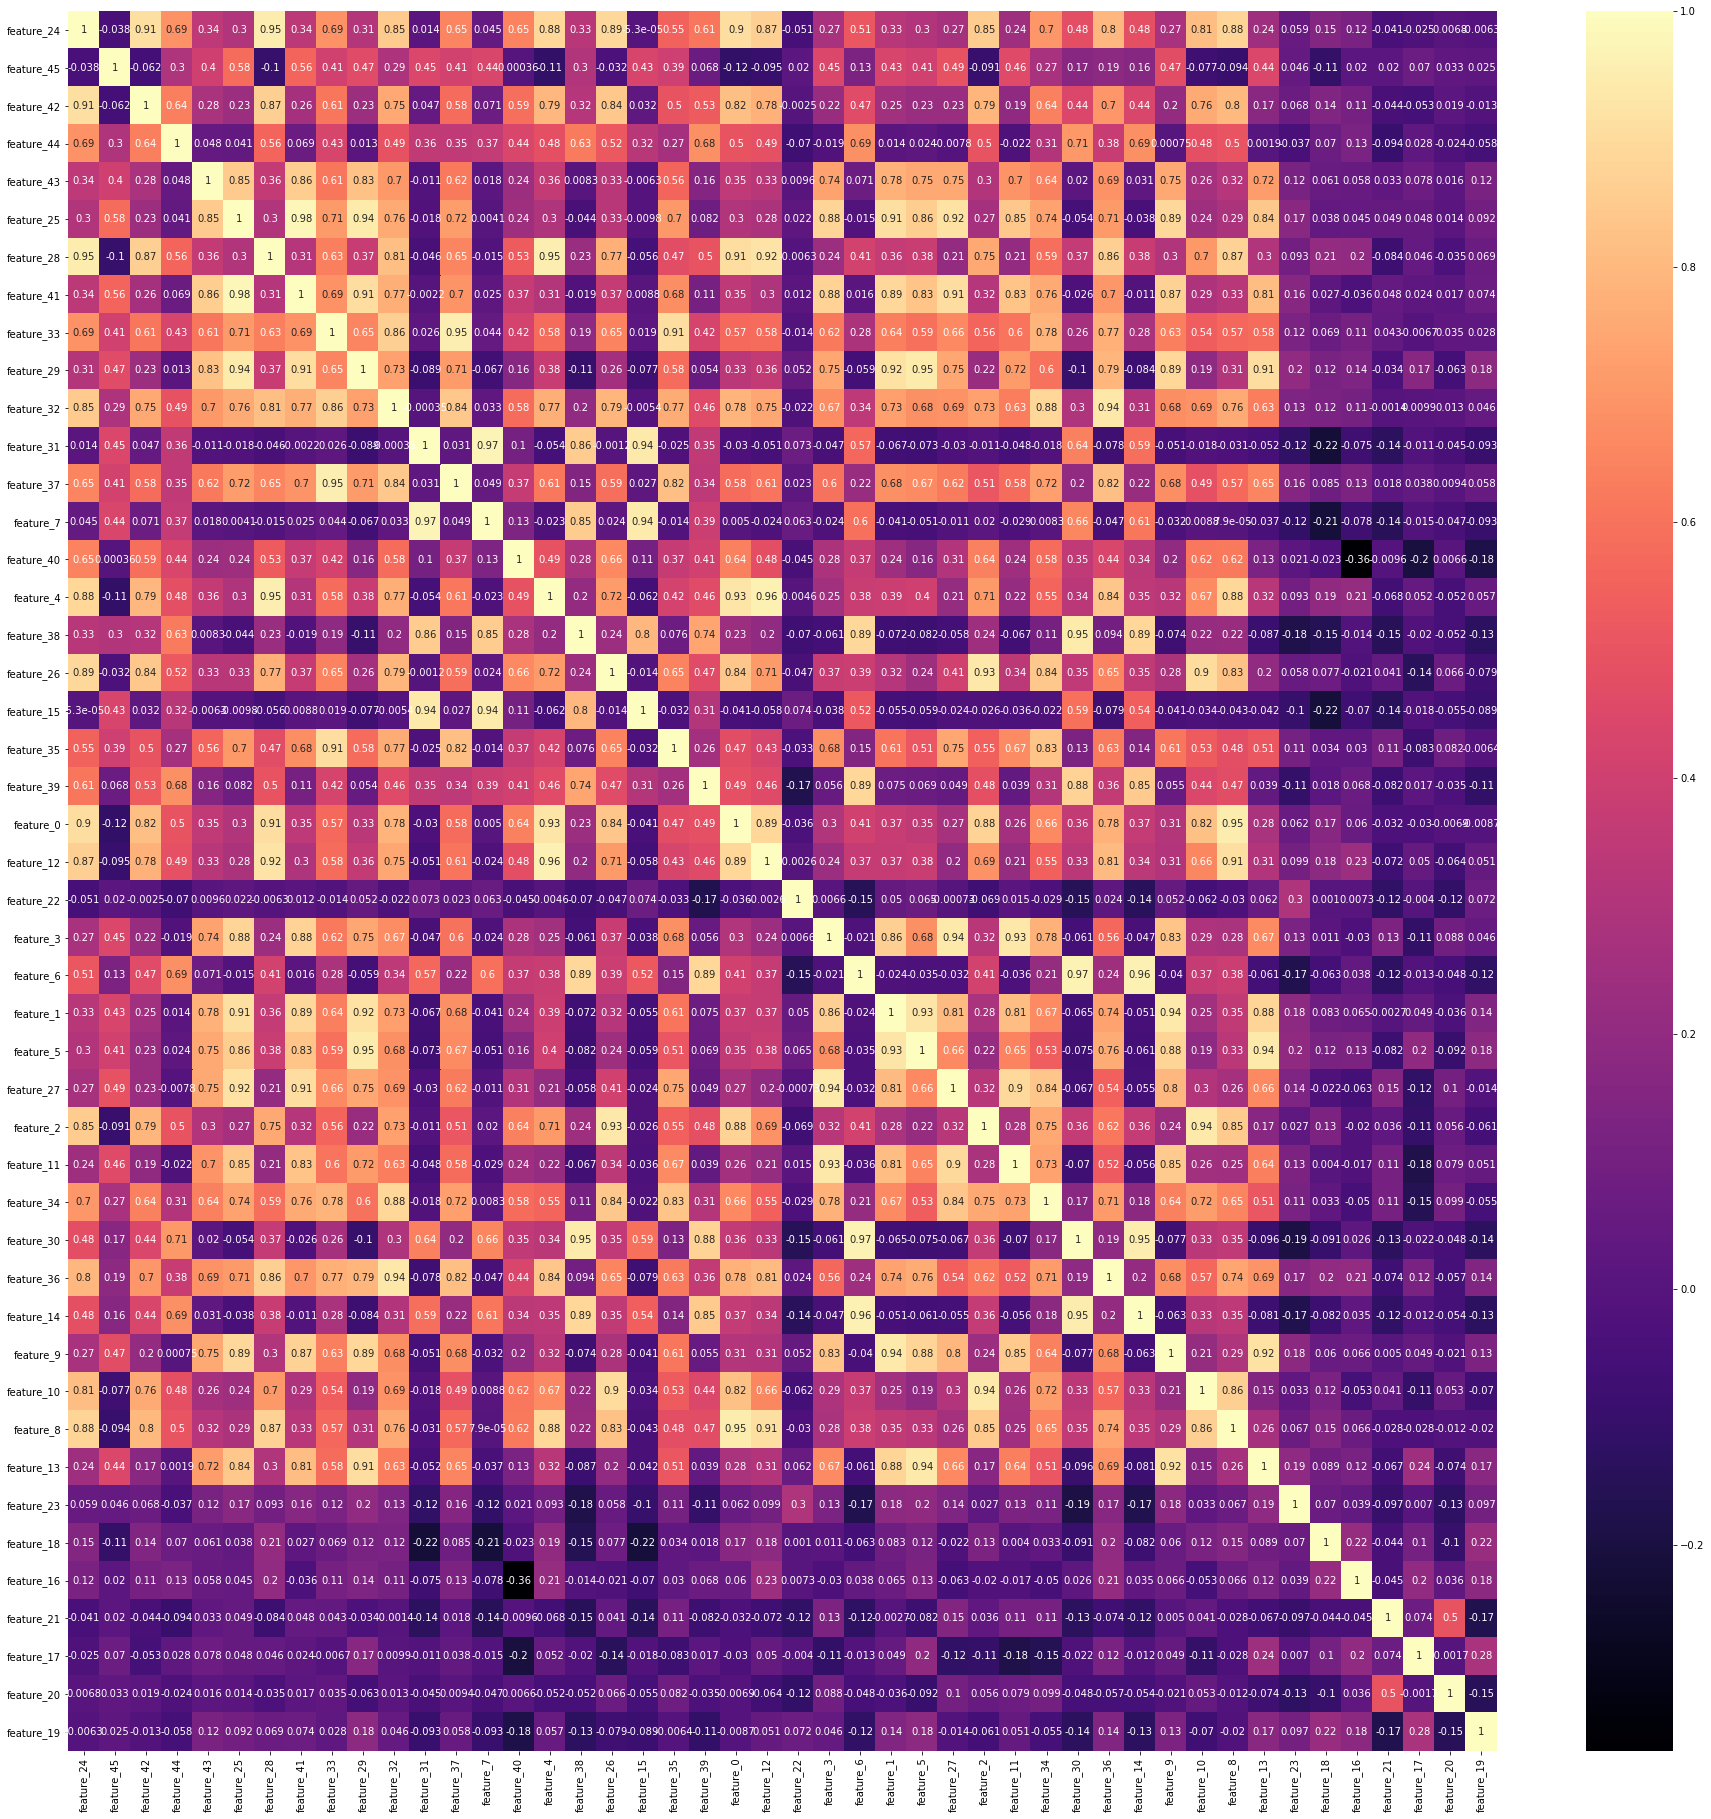

In [5]:
def prepare_data(data_: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    data = data_[data_.columns[:-3]]
    labels = data_[data_.columns[-3:-2]]

    data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.2, shuffle=True)

    print(f"Splitted data with {len(df)} rows into sets with {len(label_train)} rows for training and {len(data_test)} for testing")

    return data_train, data_test, label_train, label_test

def ada_boost(data: pd.DataFrame, 
              label: pd.DataFrame, 
              *, n_estimators: int = 100, quiet=False,
              display_weights=False) -> BaseEstimator:
    
    classifier = AdaBoostClassifier(n_estimators=n_estimators)
    if not quiet:
        print(f"Fitting AdaBoostClassifier with {n_estimators} estimators")
    classifier.fit(data, label.values.ravel())
    
 
    if display_weights:
        weights = pd.DataFrame(classifier.feature_importances_)
        weights.rename(columns = {0: "weight"}, inplace = True)
        weights.sort_values("weight", inplace=True, ascending=False)

        order = [f"feature_{index}" for index in weights.index]

        plt.figure(figsize=(32,32))
        correlation = data[order].corr()
        sns.heatmap(correlation, annot=True, cmap=plt.cm.magma)
        plt.show()

    return classifier


def random_forest(data: pd.DataFrame, 
                  label: pd.DataFrame, 
                  *, n_estimators: int = 100, quiet=False,
                  display_weights=False) -> BaseEstimator:
    
    classifier = RandomForestClassifier(n_estimators=n_estimators)
    if not quiet:
        print(f"Fitting RandomForrestClassifier with {n_estimators} estimators")
    classifier.fit(data, label.values.ravel())  
 
    if display_weights:
        weights = pd.DataFrame(classifier.feature_importances_)
        weights.rename(columns = {0: "weight"}, inplace = True)
        weights.sort_values("weight", inplace=True, ascending=False)

        order = [f"feature_{index}" for index in weights.index]

        plt.figure(figsize=(32,32))
        correlation = data[order].corr()
        sns.heatmap(correlation, annot=True, cmap=plt.cm.magma)
        plt.show()

    return classifier



data_train, data_test, label_train, label_test = prepare_data(df)

ab_classifier = ada_boost(data_train, label_train, display_weights=True)
rf_classifier = random_forest(data_train, label_train, display_weights=True)


##  Task 3: Evaluate the results [10 points]

- Print the following for both adaboost and random forest [10 points]
    - Accuracy (test)
    - Classification report
    - Confusion matrix as heatmap
      
- Which performed well adaboost or random forest? why? (answer below the code)[5 points]
 

************************************************** 
Classification report ada boost classifier 

              precision    recall  f1-score   support

         FVL       0.51      0.77      0.61        65
         FVR       0.84      0.67      0.74       111
           G       0.62      0.78      0.69        78
           H       0.31      0.45      0.37        76
          KS       0.70      0.38      0.49       165
        NMGL       0.61      0.56      0.58        97
        NMGR       0.46      0.57      0.51        80

    accuracy                           0.57       672
   macro avg       0.58      0.60      0.57       672
weighted avg       0.61      0.57      0.57       672

************************************************** 
Accuracy ada boost classifier 

0.5669642857142857 

************************************************** 
Confusion Matrix ada boost classifier 



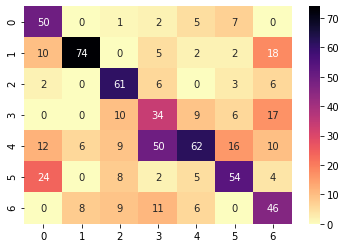

************************************************** 
Classification report random forrest classifier 

              precision    recall  f1-score   support

         FVL       0.97      0.95      0.96       100
         FVR       0.88      0.90      0.89        86
           G       0.85      0.87      0.86        95
           H       0.60      0.78      0.68        85
          KS       0.78      0.68      0.72       102
        NMGL       0.83      0.88      0.85        83
        NMGR       0.87      0.73      0.79       121

    accuracy                           0.82       672
   macro avg       0.82      0.83      0.82       672
weighted avg       0.83      0.82      0.82       672

************************************************** 
Accuracy random forrest classifier 

0.8199404761904762 

************************************************** 
Confusion Matrix random forrest classifier 



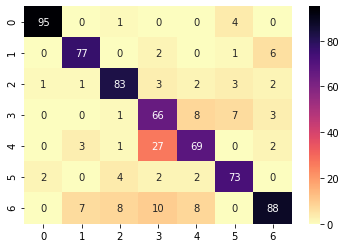

In [6]:
def evaluation(predict: np.array, test_label: pd.DataFrame, *, title: str = None, full_report=False):
    
    if not full_report:
        return accuracy_score(predict, test_label)
    
    print("*"*50, f"\nClassification report {title}", "\n")
    
    print(classification_report(predict, test_label))
    
    print("*"*50, f"\nAccuracy {title}", "\n")
    
    print(accuracy_score(predict, test_label), "\n")
    
    print("*"*50, f"\nConfusion Matrix {title}", "\n")
    
    
    confusion = confusion_matrix(predict, test_label)
    sns.heatmap(confusion, annot=True, cmap=plt.cm.magma_r)
    plt.show()
    
   
    

ab_predictions = ab_classifier.predict(data_test)
rf_predictions = rf_classifier.predict(data_test)

evaluation(ab_predictions, label_test, title="ada boost classifier", full_report=True)
evaluation(rf_predictions, label_test, title="random forrest classifier", full_report=True)


- Looking at the results we can see that the Random forest method perform better than Ada Boost
- There could be few reasons for this 
    - In Ada boost it will try to learn and train from noisy data.Which introduce error to the final solution.
    - When comparing with Random forest method Ada Boost perform worst when there are irrelevant features in the training data
    - Unlike Ada boost , random forest only use a subset of the features while AdaBoost use all. This allows Random forest to be less susceptible to noisy data. 

## Task 4: Complexity curve [15 points]
- Plot the complexity curve for aacuracy score for 200 tree number [Refer lecture slide 9]
    - Adaboost for test and train [10 points]
    - Random forest for test and train [10 points]
    
Note:- This may take a lot of time and RAM kindly do it in google Colab if the laptop doesn't have GPU

100%|██████████| 40/40 [01:27<00:00,  2.19s/it]


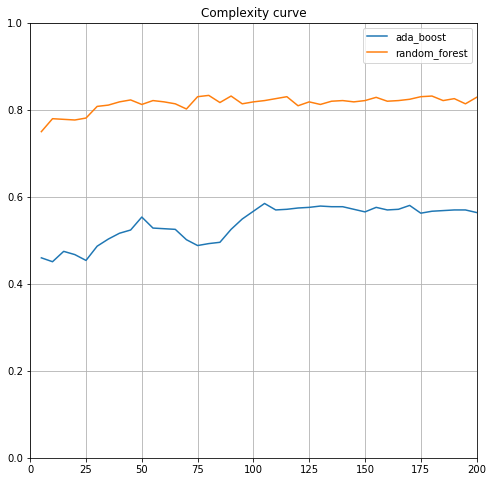

In [7]:

# THERE IS NO RELEVANT SLIDE 9 in none of those presentations: 07-Ensembles, 08-AdaBoost, 09-RandomForest
# This Homework is especially BAD documented. Please rework.
# We are assuming you mean the accuracy in relation to the used number of estimators.

def evaluate_estimator(classifier_function: Callable, 
                     data_train: pd.DataFrame, 
                     data_test: pd.DataFrame,
                     label_train: pd.DataFrame, 
                     label_test,
                     n_estimators: int):
    
    classifier = classifier_function(data_train, label_train, n_estimators=n_estimators, quiet=True)
    predictions = classifier.predict(data_test) 
    return evaluation(predictions, label_test)


def complexity_curve(*classifier_factories, 
                     start: int = 5, stop: int = 205, step: int = 5,
                    data_train: pd.DataFrame, data_test: pd.DataFrame, 
                    label_train: pd.DataFrame, label_test: pd.DataFrame):
    
    results = {}
    
    
    for n_estimators in tqdm(range(start, stop, step)):
        for classifier_factory in classifier_factories:
            
            if classifier_factory.__name__ not in results:
                results[classifier_factory.__name__] = []
                
            accuracy = evaluate_estimator(classifier_factory, data_train, data_test, label_train, label_test, n_estimators)
            results[classifier_factory.__name__].append({"n_estimators": n_estimators, "accuracy": accuracy})

        
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    
    for name, values in results.items():

        ax.plot([x["n_estimators"] for x in values],
               [x["accuracy"] for x in values], label=name)

    ax.set_ylim((0, 1))
    ax.set_xlim((0, 200))
    ax.set_title("Complexity curve")
    ax.legend()
    ax.grid()
    plt.show()

estimators_accuracy = complexity_curve(ada_boost, random_forest, 
                                       data_test=data_test, data_train=data_train, 
                                       label_test=label_test, label_train=label_train)

## Task 5: Is your code generic? [10 points]
- If need to perform the above operations but the extraction based on nest-3 will it do if the file name alone is changed?

Read 28 csv files from the folder 'dataset'
Splitted data with 3360 rows into sets with 672 rows for training and 168 for testing
Fitting AdaBoostClassifier with 100 estimators


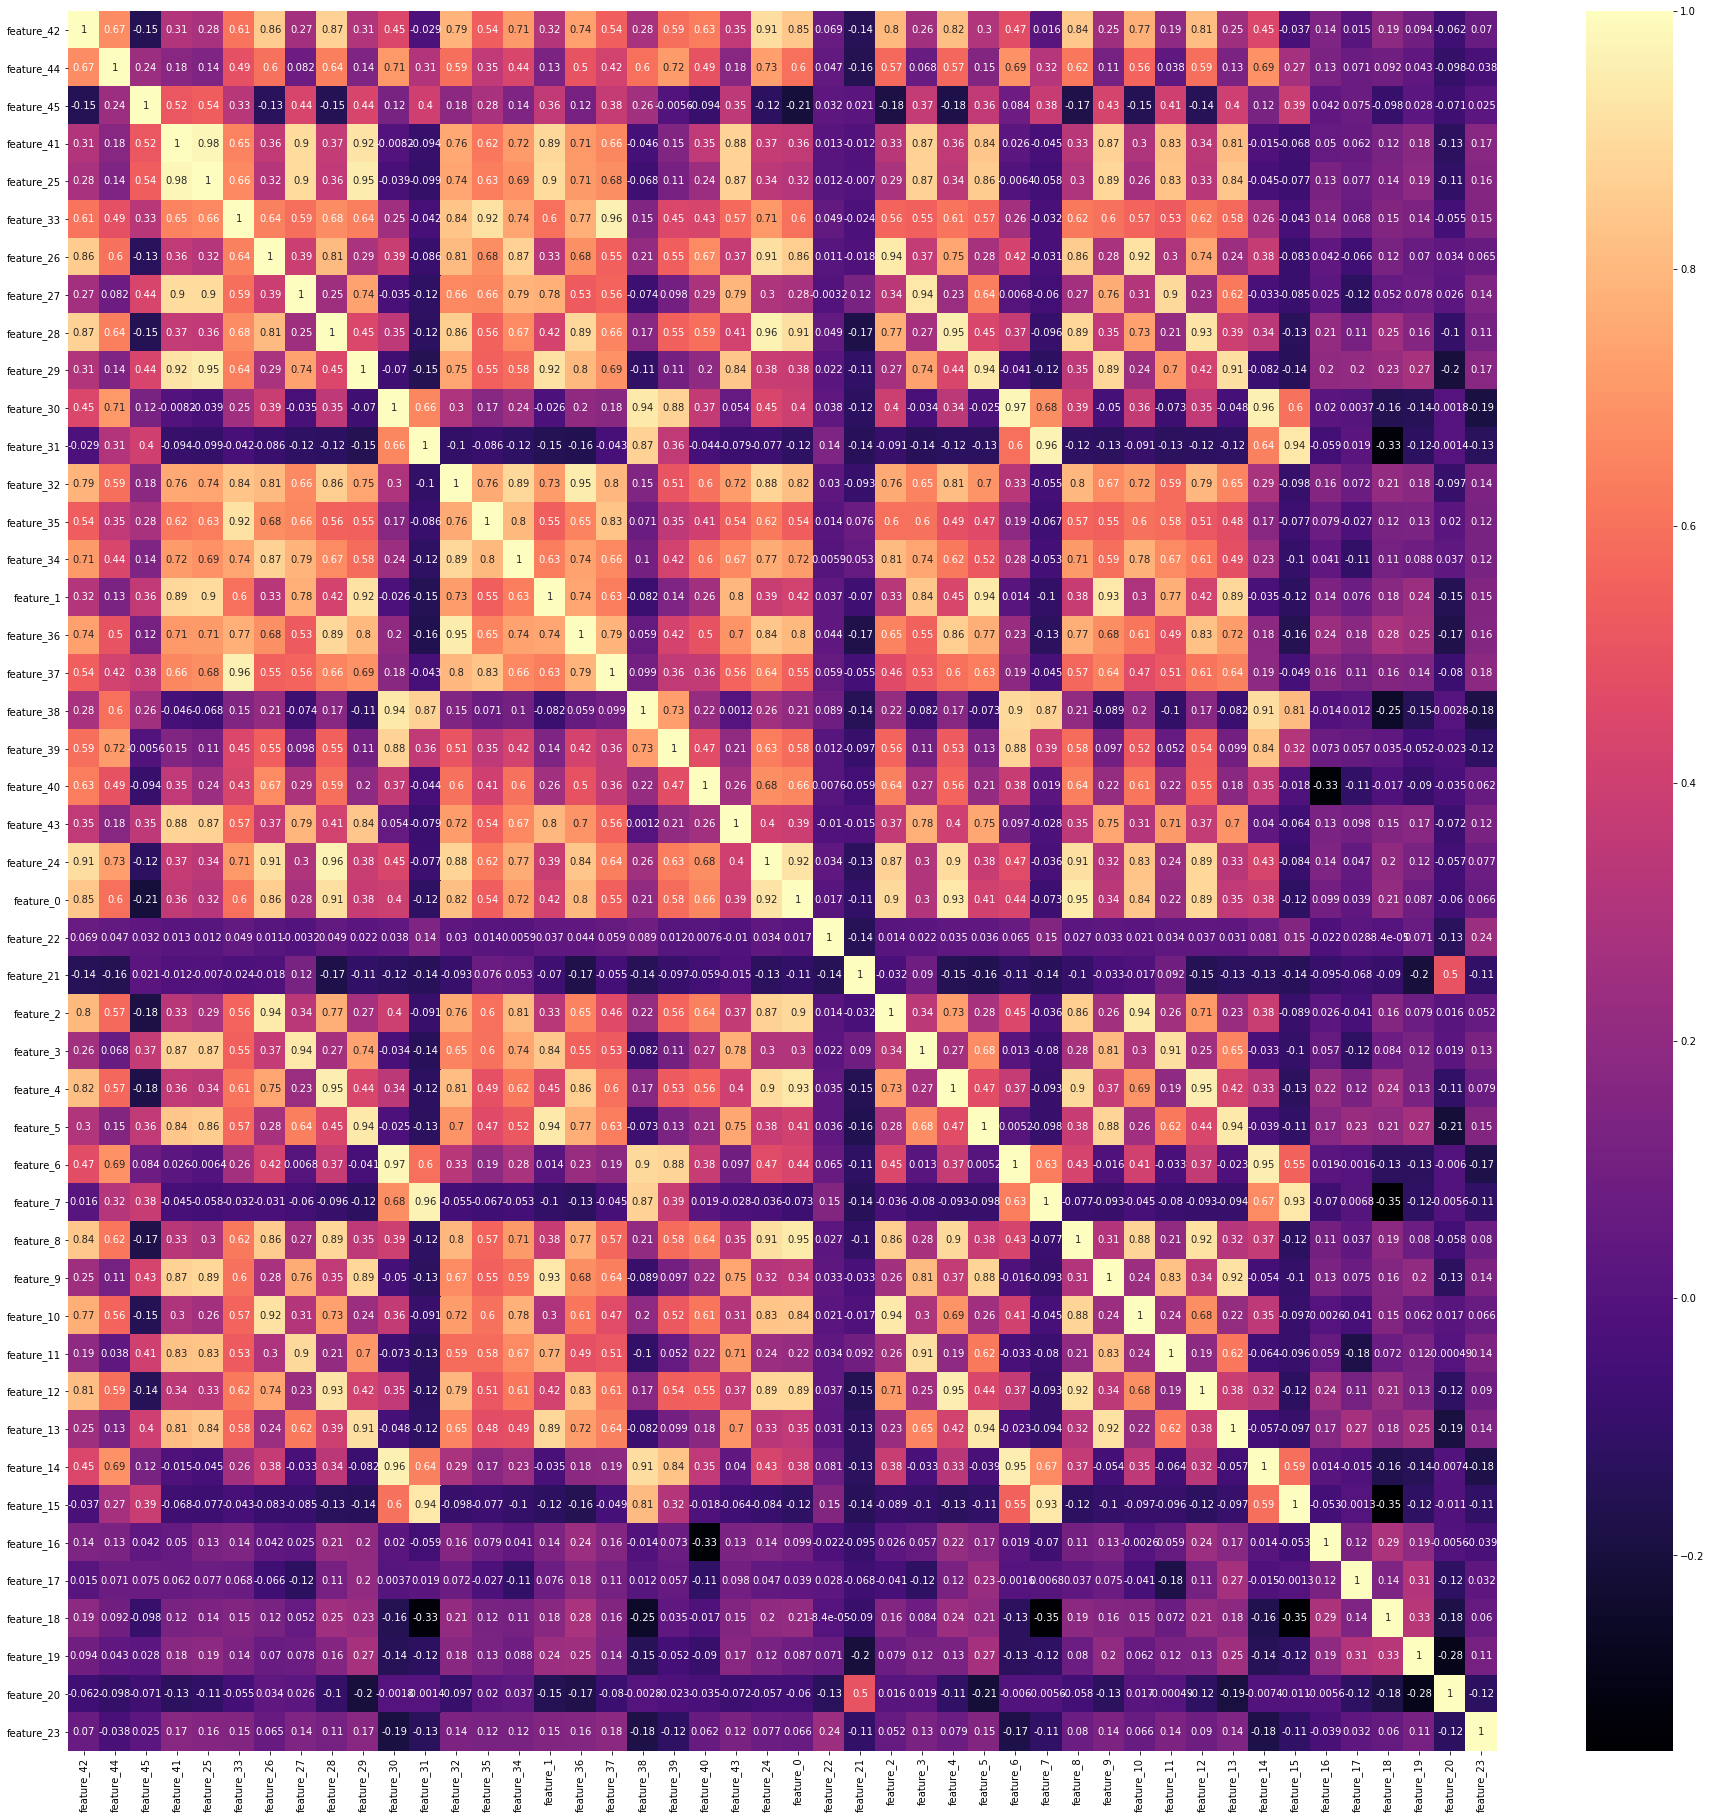

Fitting RandomForrestClassifier with 100 estimators


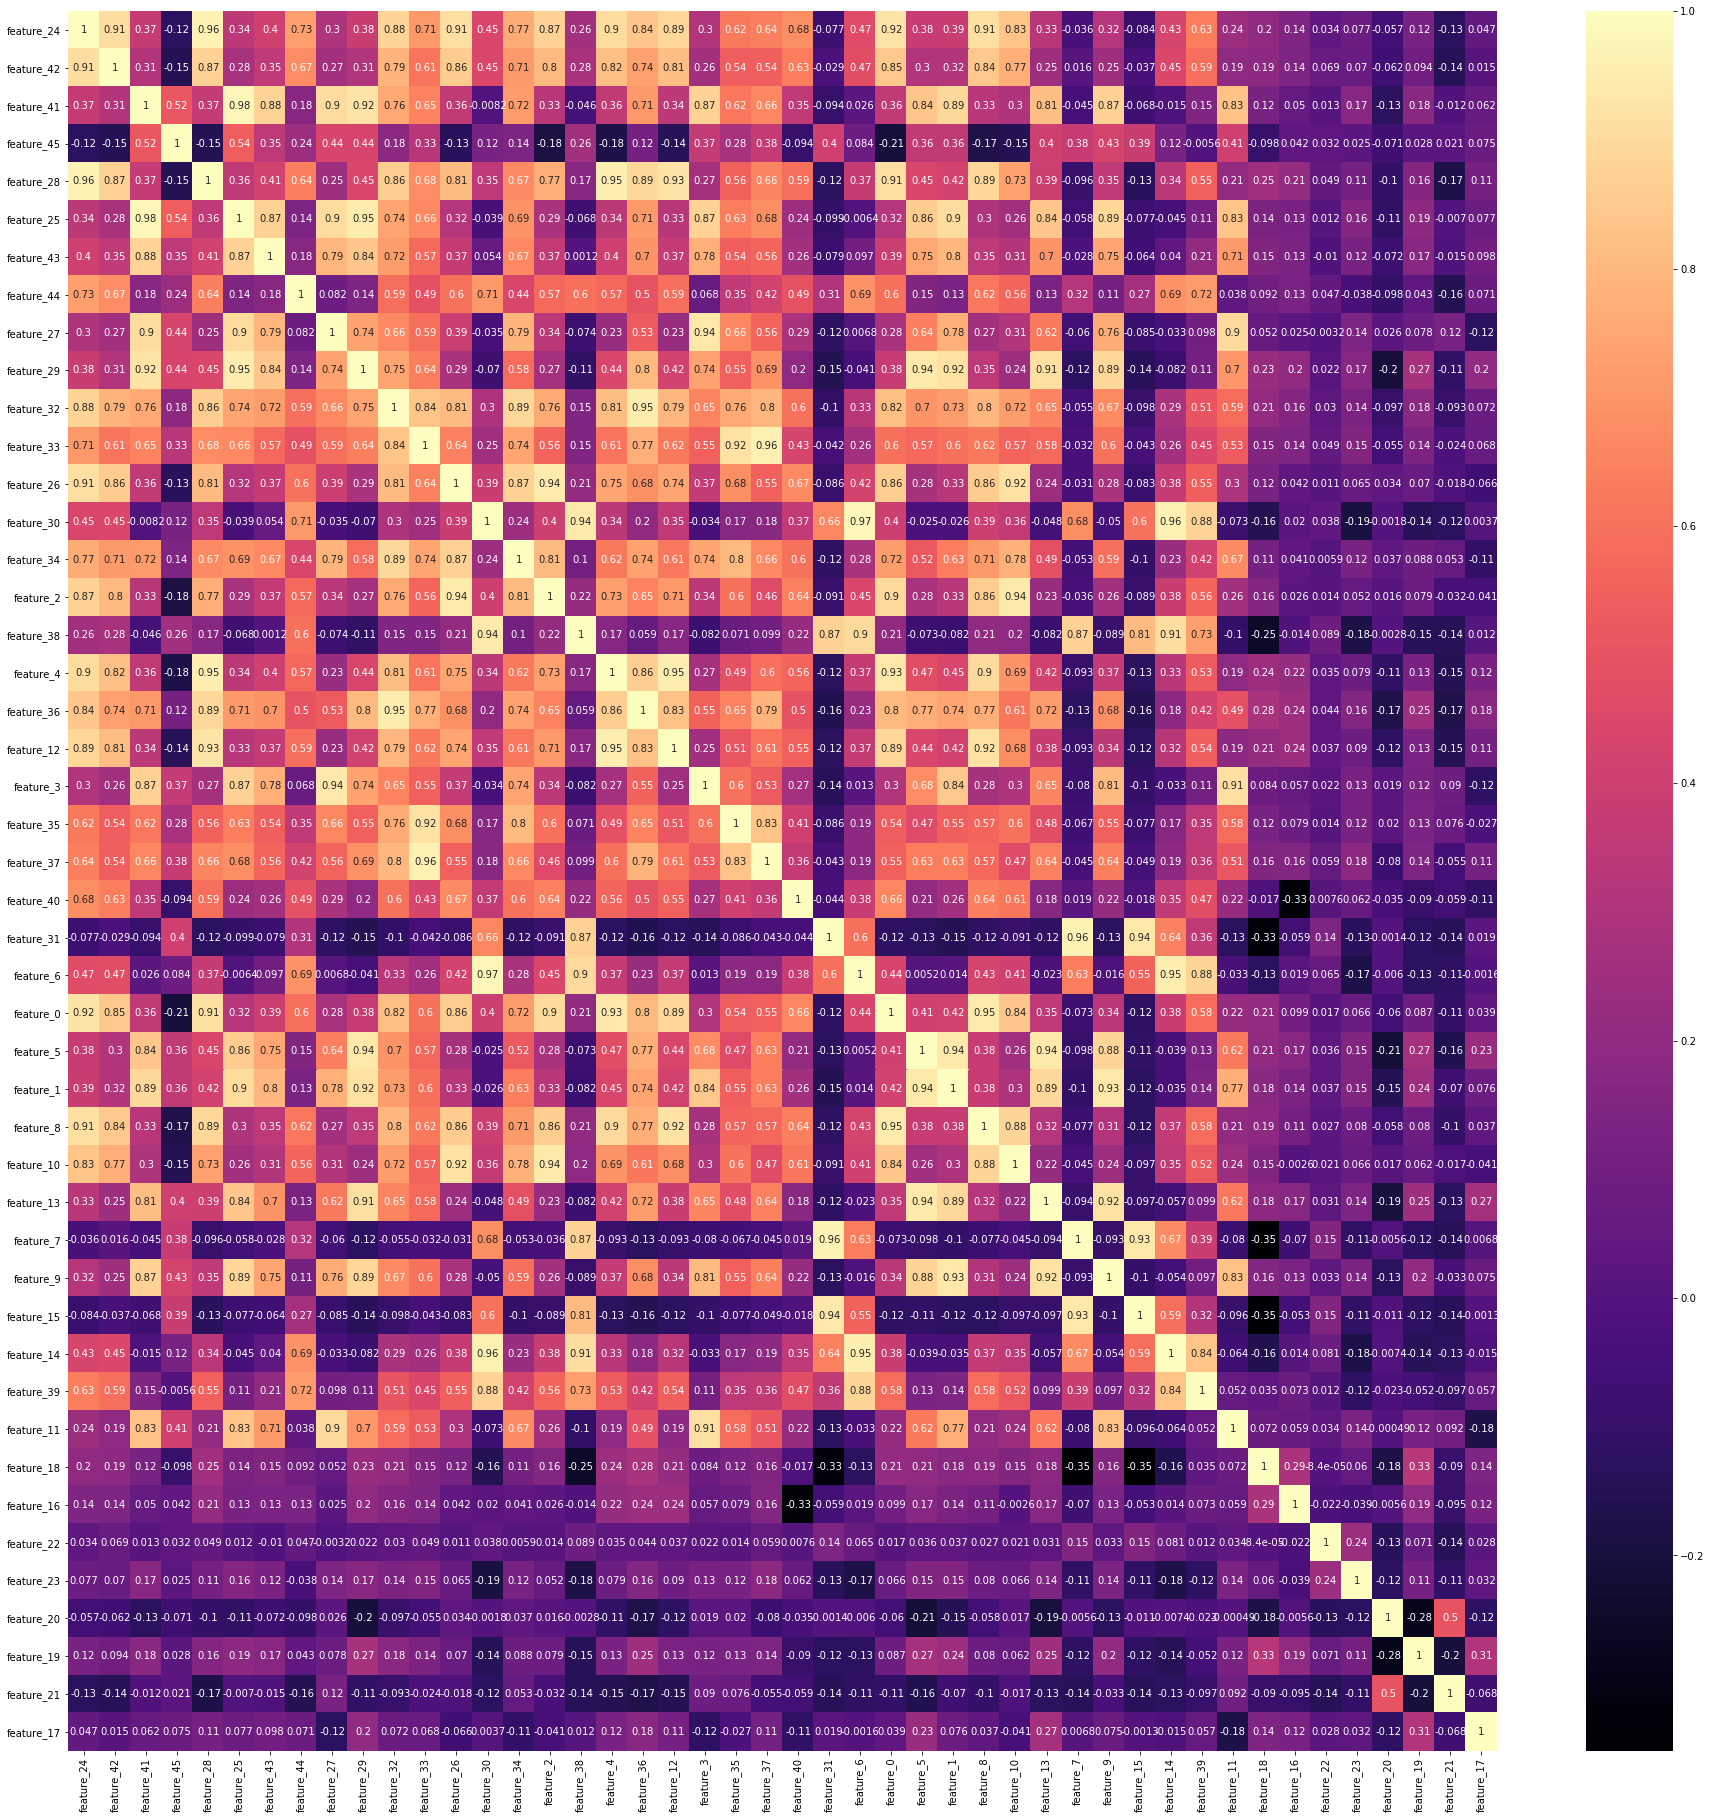

************************************************** 
Classification report ada boost classifier 

              precision    recall  f1-score   support

         FVL       0.58      0.94      0.71        16
         FVR       0.91      0.87      0.89        23
           G       0.95      0.25      0.40        83
           H       0.00      0.00      0.00         0
          KS       0.63      0.63      0.63        27
        NMGL       0.36      0.42      0.39        19
        NMGR       0.00      0.00      0.00         0

    accuracy                           0.48       168
   macro avg       0.49      0.44      0.43       168
weighted avg       0.79      0.48      0.53       168

************************************************** 
Accuracy ada boost classifier 

0.48214285714285715 

************************************************** 
Confusion Matrix ada boost classifier 



/home/sd/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sd/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sd/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


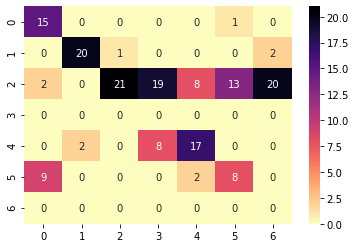

************************************************** 
Classification report random forrest classifier 

              precision    recall  f1-score   support

         FVL       0.92      1.00      0.96        24
         FVR       1.00      0.88      0.94        25
           G       0.91      0.91      0.91        22
           H       0.85      0.82      0.84        28
          KS       0.89      0.96      0.92        25
        NMGL       0.91      0.95      0.93        21
        NMGR       0.95      0.91      0.93        23

    accuracy                           0.92       168
   macro avg       0.92      0.92      0.92       168
weighted avg       0.92      0.92      0.92       168

************************************************** 
Accuracy random forrest classifier 

0.9166666666666666 

************************************************** 
Confusion Matrix random forrest classifier 



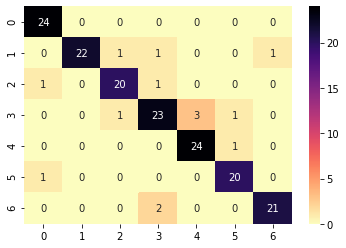

100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


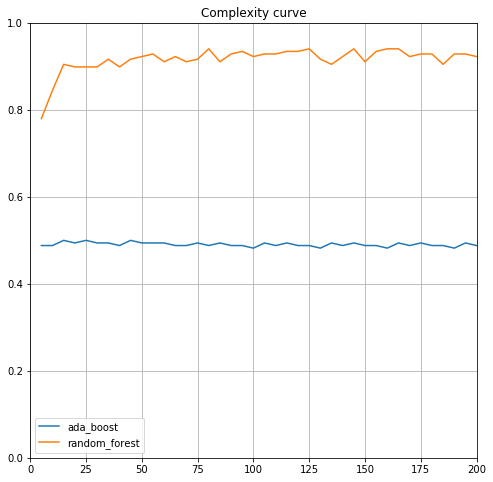

In [8]:
# THIS IS NO GOOD!!
# filename = None
# data = extract_data(filename)
# predict, test_label = randomforest(data, label)
# evaluation(predict, test_label)
# complexity_curve(data, label, tree_number)

# every extract data method should have the path to the data as argument.
# if i only want nest 3, i can use the parameter: only_nest
data = extract_data("./dataset/", only_nest=3)

data_train, data_test, label_train, label_test = prepare_data(data)

ab_classifier = ada_boost(data_train, label_train, display_weights=True)
rf_classifier = random_forest(data_train, label_train, display_weights=True)

ab_predictions = ab_classifier.predict(data_test)
rf_predictions = rf_classifier.predict(data_test)

evaluation(ab_predictions, label_test, title="ada boost classifier", full_report=True)
evaluation(rf_predictions, label_test, title="random forrest classifier", full_report=True)

estimators_accuracy = complexity_curve(ada_boost, random_forest, 
                                       data_test=data_test, data_train=data_train, 
                                       label_test=label_test, label_train=label_train)